## Random Forest Analysis

In [76]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [77]:
df = pd.read_csv("./weatherAUS_cleaned.csv", index_col="Date")
df_melb = df[df.Location == "Melbourne"].copy().drop(columns=["Location"])
df_melb.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Temp,RainToday,RISK_MM,RainTomorrow,is9AM
Date,,,,,,,,,,,,,,
2008-07-01,9.5,15.4,2.0,12.0,63.0,12.0,37.0,60.0,1006.8,11.0,1,0.6,0,1
2008-07-02,11.0,14.5,0.6,12.0,63.0,12.0,30.0,66.0,1013.4,11.8,0,1.4,1,1
2008-07-03,8.4,14.1,1.4,12.0,39.0,12.0,17.0,72.0,1024.8,10.6,1,0.6,0,1
2008-07-04,9.1,14.5,0.6,4.0,19.0,15.0,9.0,87.0,1030.2,10.2,0,0.0,0,1
2008-07-05,4.3,15.5,0.0,0.0,52.0,0.0,24.0,81.0,1028.9,5.5,0,0.0,0,1


In [78]:
# shift dataframes to make supervisable
def shift_ts_data(df, n_train_days=1, n_pred_days=1):
    df_temp = df.copy()
    cols = list()
    for i in range(n_train_days, 0, -1):
        cols.append(df_temp.shift(i))
    for i in range(0, n_pred_days):
        cols.append(df_temp.shift(-i))
    agg = pd.concat(cols, axis=1)
    return agg.values

In [79]:
# Make prediction for single value
def rf_prediction(train, testX, pred_idx=-1):
    train = np.asarray(train)
    X, y = train[:, :pred_idx], train[:, pred_idx]
    model = RandomForestRegressor(n_estimators=800)
    model.fit(X, y)
    return model.predict([testX])[0]

# Run model on dataset
def validate_rf(data, test_size=None, pred_idx=-1):
    if test_size is None:
        test_size = 0
    if type(test_size) is float:
        test_size = min(int(len(data) * test_size), len(data))

    train, test = data[:-test_size, :], data[-test_size:, :]
    prev_samples = train.tolist()
    predictions = list()
    for i in range(test_size):
        X, y = test[i, :pred_idx], test[i, pred_idx]
        y_hat = rf_prediction(prev_samples, X)
        predictions.append(y_hat)
        prev_samples.append(test[i])
        print("===={}% done====".format(i * 100 / test_size))

    MSE = mean_squared_error(test[:, pred_idx], predictions)
    return MSE, test[:, pred_idx], predictions

====0.0% done====
====6.666666666666667% done====
====13.333333333333334% done====
====20.0% done====
====26.666666666666668% done====
====33.333333333333336% done====
====40.0% done====
====46.666666666666664% done====
====53.333333333333336% done====
====60.0% done====
====66.66666666666667% done====
====73.33333333333333% done====
====80.0% done====
====86.66666666666667% done====
====93.33333333333333% done====
MSE: 0.000


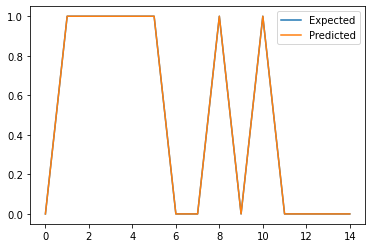

In [80]:
shift_melb = shift_ts_data(df_melb, n_train_days=2)
shift_melb = shift_melb[~np.isnan(shift_melb).any(axis=1)]
shift_melb = np.delete(shift_melb, -1, 1)

MSE, y, y_hat = validate_rf(shift_melb, 15, -1)

print('MSE: %.3f' % MSE)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(y_hat, label='Predicted')
plt.legend()
plt.show()

In [81]:
print(shift_melb.shape)

(6729, 41)
